In [1]:
# Imports and basic settings
import os
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)
pd.set_option('display.max_columns', 200)

In [3]:
# Paths and data loading
BASE = '/Users/khaneapple/Documents/freelance/analytic_ai'
PATH_NMF = os.path.join(BASE, 'data/nmf_clusters_continent_pronouns_age_20.csv')
PATH_EXP = os.path.join(BASE, 'data/2024_expertise_shape_final.csv')

print('Loading data...')
nmf = pd.read_csv(PATH_NMF)
exp = pd.read_csv(PATH_EXP)

print(f'nmf: {nmf.shape}, exp: {exp.shape}')
print('\nSample key columns in nmf:')
print([c for c in nmf.columns if any(x in c for x in ['duration','count_','reputation','cluster'])][:20])
print('\nSample columns in expertise:')
print(list(exp.columns))

# show a few rows
nmf.head(2), exp.head(2)

Loading data...
nmf: (92289, 30), exp: (556445, 8)

Sample key columns in nmf:
['reputation', 'active_duration', 'count_posthistory', 'count_comments', 'count_badges', 'count_questions', 'count_answers', 'total_duration', 'cluster_nmf_5', 'cluster_nmf_10', 'cluster_nmf_15', 'cluster_nmf_20']

Sample columns in expertise:
['answer_owner_id', 'expert_topics', 'expert_topic_count', 'general_topics', 'general_topic_count', 'novice_topics', 'novice_topic_count', 'expertise_shape']
nmf: (92289, 30), exp: (556445, 8)

Sample key columns in nmf:
['reputation', 'active_duration', 'count_posthistory', 'count_comments', 'count_badges', 'count_questions', 'count_answers', 'total_duration', 'cluster_nmf_5', 'cluster_nmf_10', 'cluster_nmf_15', 'cluster_nmf_20']

Sample columns in expertise:
['answer_owner_id', 'expert_topics', 'expert_topic_count', 'general_topics', 'general_topic_count', 'novice_topics', 'novice_topic_count', 'expertise_shape']


(   userid  reputation  downvotes  upvotes  views  active_duration  \
 0       9       25640          4       46   7960              187   
 1      13      221192        193     5135  46081              170   
 
    count_posthistory  count_comments  count_badges  count_questions  \
 0                108              22            97               19   
 1               3825            3846           875               10   
 
    count_answers  aboutme_length expertise_shape  total_duration country  \
 0             45               5               H             190      US   
 1           2121             194               C             190      US   
 
    individualistic_aboutme  collectivistic_aboutme  individualistic_comments  \
 0                        0                       0                         3   
 1                        3                       4                       697   
 
    collectivistic_comments  comment_length  comment_sentiment  \
 0                       1

In [4]:
# --- Validate columns, compute churn label ---
THRESHOLD_GAP_MONTHS = 12.0

# detect userid columns and normalize to 'userid'
nmf_id_candidates = [c for c in nmf.columns if c.lower() in ('userid','user_id','answer_owner_id','owner_id')]
exp_id_candidates = [c for c in exp.columns if c.lower() in ('userid','user_id','answer_owner_id','owner_id')]

if nmf_id_candidates:
    if 'userid' not in nmf.columns:
        nmf = nmf.rename(columns={nmf_id_candidates[0]: 'userid'})
else:
    raise KeyError('nmf does not contain a user id column. columns: ' + str(list(nmf.columns)))

if exp_id_candidates:
    if 'userid' not in exp.columns:
        exp = exp.rename(columns={exp_id_candidates[0]: 'userid'})
else:
    print('Warning: expertise dataframe has no user id column (userid); merge may be empty. Expertise columns:')
    print(list(exp.columns))

# detect expertise column and normalize to 'expertise_shape'
exp_shape_candidates = [c for c in exp.columns if 'expertise' in c.lower() or 'shape' in c.lower()]
if exp_shape_candidates:
    if 'expertise_shape' not in exp.columns:
        exp = exp.rename(columns={exp_shape_candidates[0]: 'expertise_shape'})
else:
    print('Warning: expertise_shape column not found in expertise dataframe. Columns:')
    print(list(exp.columns))

# coerce durations to numeric
for col in ['total_duration', 'active_duration']:
    if col in nmf.columns:
        nmf[col] = pd.to_numeric(nmf[col], errors='coerce').fillna(0)
    else:
        print(f'Warning: column {col} not found in nmf.')

# compute inactive_gap and churn label
nmf['inactive_gap'] = (nmf.get('total_duration', 0) - nmf.get('active_duration', 0)).clip(lower=0)
nmf['y_churn'] = (nmf['inactive_gap'] >= THRESHOLD_GAP_MONTHS).astype(int)

# merge with expertise if available
if 'userid' in exp.columns:
    data = nmf.merge(exp[['userid', 'expertise_shape']].drop_duplicates(subset=['userid']), on='userid', how='left')
else:
    data = nmf.copy()

print('Data preparation complete.')
print('\nFinal nmf columns sample:')
print([c for c in nmf.columns if any(x in c for x in ['userid','duration','inactive_gap','active_duration','cluster','count_'])][:40])
print('\nExpertise columns (after normalize):')
print([c for c in exp.columns][:40])

print('\nChurn label distribution:')
print(data['y_churn'].value_counts(dropna=False))
print(f'Overall churn rate: {data["y_churn"].mean():.1%}')

# show sample rows
data[['userid','inactive_gap','y_churn'] + ([ 'cluster_nmf_20' ] if 'cluster_nmf_20' in data.columns else []) + ([ 'expertise_shape' ] if 'expertise_shape' in data.columns else [])].head(6)

Data preparation complete.

Final nmf columns sample:
['userid', 'active_duration', 'count_posthistory', 'count_comments', 'count_badges', 'count_questions', 'count_answers', 'total_duration', 'cluster_nmf_5', 'cluster_nmf_10', 'cluster_nmf_15', 'cluster_nmf_20', 'inactive_gap']

Expertise columns (after normalize):
['userid', 'expert_topics', 'expert_topic_count', 'general_topics', 'general_topic_count', 'novice_topics', 'novice_topic_count', 'expertise_shape']

Churn label distribution:
y_churn
0    57707
1    34582
Name: count, dtype: int64
Overall churn rate: 37.5%


,userid,inactive_gap,y_churn,cluster_nmf_20
0,9,3,0,11
1,13,20,1,3
2,33,0,0,0
3,35,13,1,11
4,56,0,0,8
5,58,0,0,19


# Phase 1 — Question 1: Defining Churn per Persona

Goal: define and compute a churn metric (y_churn) for each persona (`cluster_nmf_20`), produce tables and visualizations, and save outputs for reporting.

Method summary:
- Default threshold: 12 months of inactivity (configurable)
- Calculation: inactive_gap = total_duration - active_duration
- Label: y_churn = 1 if inactive_gap >= threshold
- Outputs: churn rate by persona, churn rate by expertise_shape, persona × expertise crosstab

Notebook flow: imports → load data → validation & compute → persona aggregation → visualizations → save outputs


Top personas by churn rate:


,cluster_nmf_20,users,churners,churn_rate,avg_inactive_gap
18,18,1080,625,0.578704,31.072222
9,9,5254,3005,0.571945,31.420822
19,19,1466,837,0.570941,29.149386
16,16,3535,1624,0.459406,23.605941
11,11,2756,1230,0.446299,24.567126
1,1,13515,5971,0.441805,21.314095
4,4,9739,3741,0.384126,18.676353
5,5,18131,6830,0.376703,18.875352
2,2,2612,968,0.370597,18.025268
7,7,1472,545,0.370245,16.977582


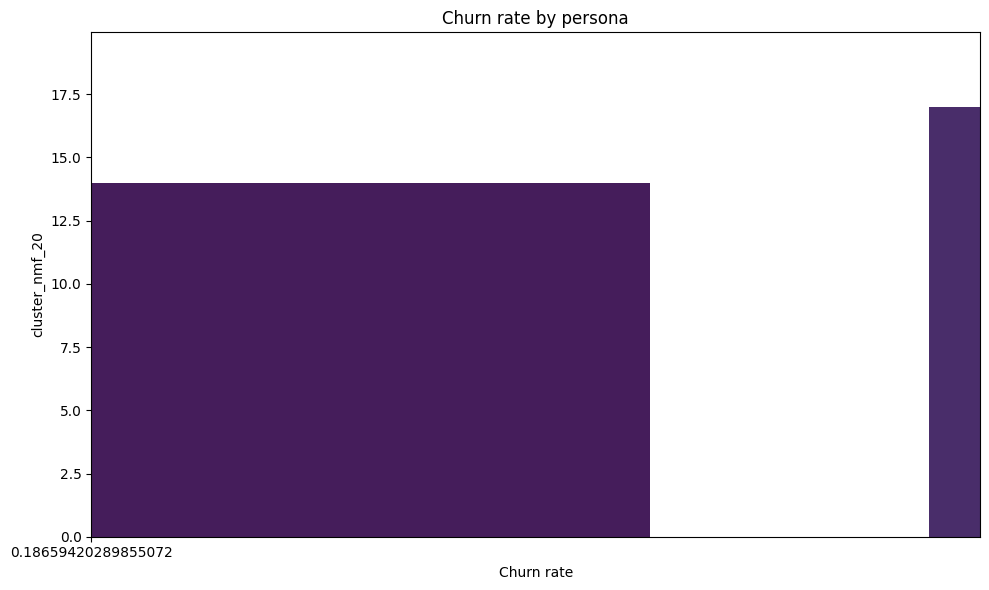

Saved persona churn table to /Users/khaneapple/Documents/freelance/analytic_ai/phase1/question_1_churn_definition/outputs/phase1_q1_churn_by_persona.csv


In [5]:
# Persona-level churn aggregation, plotting and save
import os

# Update output directory to phase1 question outputs
output_dir = os.path.join(BASE, 'phase1', 'question_1_churn_definition', 'outputs')
os.makedirs(output_dir, exist_ok=True)

persona_col = 'cluster_nmf_20' if 'cluster_nmf_20' in data.columns else ( 'cluster' if 'cluster' in data.columns else None)
if persona_col is None:
    print('Warning: No persona column found. Skipping persona aggregation.')
else:
    persona = data.groupby(persona_col).agg(
        users=('userid','nunique'),
        churners=('y_churn', 'sum'),
        churn_rate=('y_churn','mean'),
        avg_inactive_gap=('inactive_gap','mean')
    ).reset_index().sort_values('churn_rate', ascending=False)

    print('\nTop personas by churn rate:')
    display(persona.head(10))

    # Plot churn rate by persona
    plt.figure(figsize=(10,6))
    sns.barplot(data=persona, x='churn_rate', y=persona_col, palette='viridis')
    plt.xlabel('Churn rate')
    plt.title('Churn rate by persona')
    plt.xlim(0, min(1, persona['churn_rate'].max()*1.1))
    plt.tight_layout()
    plt.show()

    # save persona table
    persona_csv = os.path.join(output_dir, 'phase1_q1_churn_by_persona.csv')
    persona.to_csv(persona_csv, index=False)
    print(f'Saved persona churn table to {persona_csv}')

    # persona x expertise churn rates
    if 'expertise_shape' in data.columns:
        ct = pd.crosstab(data[persona_col], data['expertise_shape'], values=data['y_churn'], aggfunc='mean').fillna(0)
        ct_csv = os.path.join(output_dir, 'phase1_q1_churn_persona_by_expertise.csv')
        ct.to_csv(ct_csv)
        print(f'Saved persona x expertise churn rates to {ct_csv}')